In [11]:
import numpy as np
import pandas as pd
import yahoo_api as yapi
import matplotlib.pyplot as plt

In [12]:
def cppi(CPPI,M, F):
    """
    Compute portfolio's allocation according to CPPI strategy
    CPPI: Total portfolio value
    M: multiplier
    F: Protection floor
    """
    C = CPPI - F
    E = min([CPPI,max([0, M * C])])
    B = max([0,CPPI - E])
    return {'Risky Asset':E, 
            'Riskless Asset':B}

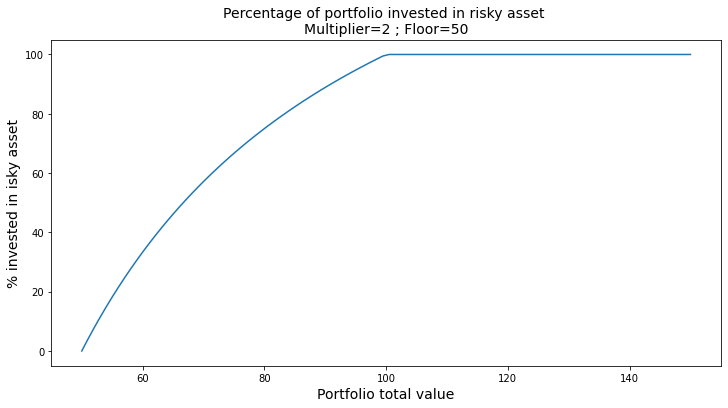

In [13]:
portfolio = np.linspace(50,150,100)
risky = [cppi(port,2,50)['Risky Asset'] for port in portfolio]

plt.figure(figsize=(12,6))
plt.plot(portfolio,risky/portfolio*100)
plt.title("Percentage of portfolio invested in risky asset \nMultiplier=2 ; Floor=50", fontsize=14)
plt.ylabel("% invested in isky asset", fontsize=14)
plt.xlabel("Portfolio total value", fontsize=14)
plt.show()

In [14]:
# This method is not from me, 
# it is a part of a MOOC taught by EDHEC Business School available on COURSERA on the next link:
# https://www.coursera.org/learn/introduction-portfolio-construction-python?

def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    peak = account_value
    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # fast way to set all values to a number
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    floorval_history = pd.DataFrame().reindex_like(risky_r)
    peak_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
        floorval_history.iloc[step] = floor_value
        peak_history.iloc[step] = peak
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r,
        "drawdown": drawdown,
        "peak": peak_history,
        "floor": floorval_history
    }
    return backtest_result

In [57]:
history = pd.DataFrame(yapi.ticker('BTC-USD').history('5y')['Close'])[-730:]
index_name = 'S&P 500'

cppi = run_cppi(risky_r=history.pct_change().dropna())
cppi['Wealth'].columns = [f'CPPI strategy applied to {index_name}']
cppi['Risky Wealth'].columns = [index_name]

floor = pd.DataFrame().reindex_like(history)
floor[:] = 1000
floor.columns = ['Floor']
cppi['Risky Allocation'].columns = [f'CPPI strategy Risky Asset allocation']

<AxesSubplot:>

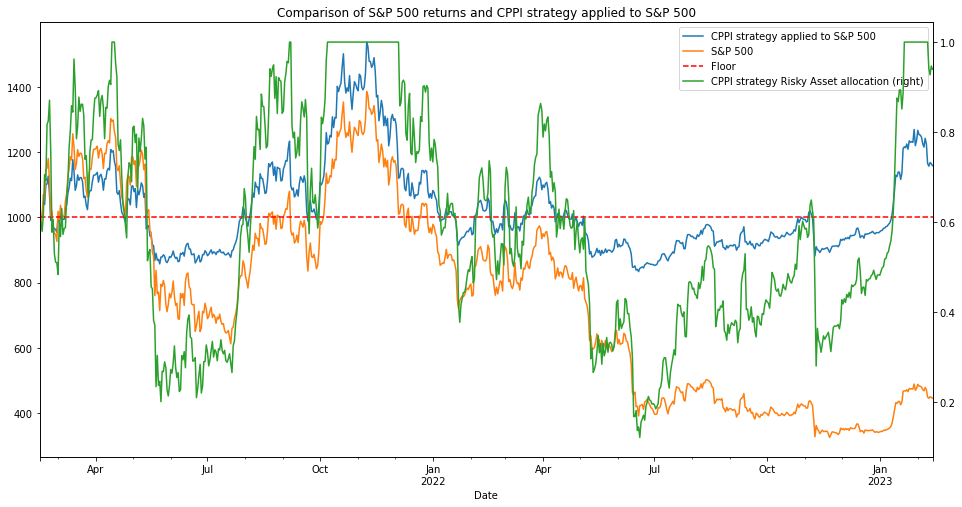

In [58]:
ax = cppi['Wealth'].plot()
cppi['Risky Wealth'].plot(ax=ax, figsize = (16,8),title=f'Comparison of {index_name} returns and CPPI strategy applied to {index_name}')
floor.plot(ax=ax, style='--', color='r')
cppi['Risky Allocation'].plot(ax=ax,secondary_y=True)
